In [1]:
import numpy as np
np.random.seed(11)
import tensorflow as tf
tf.random.set_seed(11)

2023-02-13 18:26:49.626879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hanh/anaconda3/envs/flowers/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import keras.layers as layers
from keras.models import Sequential
from keras.utils import np_utils, load_img, img_to_array

In [3]:
from sklearn.datasets import load_files
from tqdm import tqdm
import pandas as pd
import os

## Load images

In [4]:
def load_dataset(path):
    files = load_files(path)
    targets_int = np.array([int(f.split(os.sep)[4]) for f in files.filenames]) # extract the flower category
    targets_int -= 1
    targets_cat = np_utils.to_categorical(targets_int, 102)
    return files.filenames, targets_int, targets_cat

# load train, test, and validation datasets
train_files, train_targets_int, train_targets = load_dataset('./Data/Datasplit/train')
valid_files, valid_targets_int, valid_targets = load_dataset('./Data/Datasplit/valid')
test_files, test_targets_int, test_targets = load_dataset('./Data/Datasplit/test')

## Convert images to float

In [5]:
def path_to_tensor(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)      
    img = np.expand_dims(img, axis=0)  # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3)
    img = preprocess_input(img)
    return img

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████| 6149/6149 [00:29<00:00, 211.00it/s]


## Use Resnet50 weights

In [7]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#Loading the ResNet50 model with pre-trained ImageNet weights
resnet = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=inputs)

2023-02-13 18:27:52.109516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 18:27:52.114650: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
len(resnet.layers)

175

In [9]:
for layer in resnet.layers: layer.trainable = False

In [10]:
cnn = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(units=102, activation="softmax"),
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,804,902
Trainable params: 213,094
Non-t

In [11]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=True)

history = cnn.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

In [13]:
cnn.evaluate(train_tensors, train_targets)
cnn.evaluate(valid_tensors, valid_targets)
cnn.evaluate(test_tensors, test_targets);

193/193 [==============================] - 243s 1s/step - loss: 0.7347 - accuracy: 0.8260


In [14]:
cnn.save("./saved_models/cnn_resnet.h5")

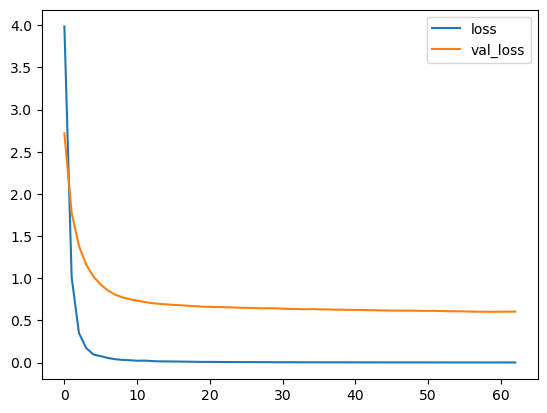

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

## Analyze the model predictions

In [16]:
# get prediction
flower_preds = [np.argmax(cnn.predict(np.expand_dims(tensor, axis=0), verbose=0)) for tensor in test_tensors]

In [37]:
# flower labels
labels = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

In [59]:
# combine the model predictions against the actual labels
results = pd.DataFrame(list(zip(np.argmax(test_targets, axis=1), flower_preds)), columns =['Target', 'Pred'])
results['Accuracy'] = (results.Target==results.Pred)*1
results['Target_label'] = results['Target'].apply(lambda x: labels[x])
results['Pred_label'] = results['Pred'].apply(lambda x: labels[x])

In [60]:
results.head()

,Target,Pred,Accuracy,Target_label,Pred_label
0,101,101,1,blackberry lily,blackberry lily
1,54,54,1,pelargonium,pelargonium
2,93,93,1,foxglove,foxglove
3,64,64,1,californian poppy,californian poppy
4,87,87,1,cyclamen,cyclamen


In [61]:
results.tail()

,Target,Pred,Accuracy,Target_label,Pred_label
6144,82,82,1,hibiscus,hibiscus
6145,64,64,1,californian poppy,californian poppy
6146,42,17,0,sword lily,peruvian lily
6147,53,53,1,sunflower,sunflower
6148,55,55,1,bishop of llandaff,bishop of llandaff


In [65]:
# Create accuracy rate for each category
summary = results.groupby(['Target', 'Target_label'])['Accuracy'].agg(['mean', 'count']).\
        rename(columns={'mean':'Acc_rate', 'count':'Size'})
summary.describe()

,Acc_rate,Size
count,102.000000,102.000000
mean,0.840268,60.284314
std,0.146594,44.276891
min,0.350000,20.000000
25%,0.758966,29.000000
50%,0.875962,46.000000
75%,0.950915,72.750000
max,1.000000,238.000000


In [66]:
summary.head()

,,Acc_rate,Size
Target,Target_label,,
0,pink primrose,0.750000,20
1,hard-leaved pocket orchid,0.850000,40
2,canterbury bells,0.350000,20
3,sweet pea,0.500000,36
4,english marigold,0.933333,45


In [67]:
# there is little correlation between the accuracy and the number of images available
summary.corr()

,Acc_rate,Size
Acc_rate,1.000000,-0.133945
Size,-0.133945,1.000000


In [68]:
summary[summary['Acc_rate']<0.75].Size.count()

20

In [69]:
# Show the top ten flower categories with the lowest model accuracy
summary.sort_values('Acc_rate')[:10]

,,Acc_rate,Size
Target,Target_label,,
2,canterbury bells,0.350000,20
38,siam tulip,0.380952,21
50,petunia,0.466387,238
95,camellia,0.478873,71
3,sweet pea,0.500000,36
81,clematis,0.532609,92
42,sword lily,0.563636,110
10,snapdragon,0.582090,67
82,hibiscus,0.612613,111


In [75]:
# Identify the pairs of wrong predictions
wrongs = results[results.Accuracy==0].groupby(['Target', 'Target_label', 'Pred', 'Pred_label']).count()\
            .rename(columns={'Accuracy':'Size'}).reset_index()

In [77]:
# Show the top 10 pairs of wrong predictions
wrongs.sort_values(['Size'], ascending=False)[:10]

,Target,Target_label,Pred,Pred_label,Size
249,50,petunia,71,azalea,16
506,87,cyclamen,77,lotus,15
253,50,petunia,82,hibiscus,12
239,50,petunia,29,sweet william,11
434,81,clematis,43,poinsettia,11
41,10,snapdragon,2,canterbury bells,9
603,95,camellia,96,mallow,8
232,50,petunia,3,sweet pea,8
250,50,petunia,75,morning glory,8
230,50,petunia,0,pink primrose,7


In [80]:
# Canterburry bells had the model accuracy of 35%
# The model was mistaken canterbury bells mostly with monkshood because they share similar colors
wrongs[wrongs.Target==2].sort_values('Size', ascending=False)

,Target,Target_label,Pred,Pred_label,Size
10,2,canterbury bells,8,monkshood,3
9,2,canterbury bells,3,sweet pea,2
11,2,canterbury bells,10,snapdragon,2
12,2,canterbury bells,27,stemless gentian,2
13,2,canterbury bells,29,sweet william,2
14,2,canterbury bells,57,geranium,1
15,2,canterbury bells,95,camellia,1


In [81]:
# Siam tulip had the model accuracy of 38%. 
# The model was mistaken siam tulip mostly with sweet pea. 
# Without flower knowledge I had a tough time distinguish them.
wrongs[wrongs.Target==38].sort_values('Size', ascending=False)

,Target,Target_label,Pred,Pred_label,Size
156,38,siam tulip,3,sweet pea,3
157,38,siam tulip,10,snapdragon,1
158,38,siam tulip,14,yellow iris,1
159,38,siam tulip,72,water lily,1
160,38,siam tulip,73,rose,1
161,38,siam tulip,74,thorn apple,1
162,38,siam tulip,76,passion flower,1
163,38,siam tulip,77,lotus,1
164,38,siam tulip,87,cyclamen,1
165,38,siam tulip,92,ball moss,1


In [82]:
# Petunia had the model accuracy of 47%. 
# The model was mistaken petunia mostly with azalea.
# While I can tell the difference between these categories, the model was confused because they share similar colors
wrongs[wrongs.Target==50].sort_values('Size', ascending=False)

,Target,Target_label,Pred,Pred_label,Size
249,50,petunia,71,azalea,16
253,50,petunia,82,hibiscus,12
239,50,petunia,29,sweet william,11
232,50,petunia,3,sweet pea,8
250,50,petunia,75,morning glory,8
230,50,petunia,0,pink primrose,7
235,50,petunia,10,snapdragon,7
252,50,petunia,81,clematis,6
240,50,petunia,31,garden phlox,6
245,50,petunia,52,primula,6
